# Imports 

In [ ]:
!pip install --upgrade pip
!pip install --upgrade boto3
!pip install sagemaker
!pip install fsspec 
!pip install s3fs
!pip install xgboost
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached boto3-1.28.83-py3-none-any.whl.metadata (6.7 kB)
  Using cached botocore-1.31.83-py3-none-any.whl.metadata (6.1 kB)
  Using cached s3transfer-0.7.0-py3-none-any.whl.metadata (1.8 kB)
Using cached boto3-1.28.83-py3-none-any.whl (135 kB)
Using cached botocore-1.31.83-py3-none-any.whl (11.3 MB)
Using cached s3transfer-0.7.0-py3-none-any.whl (79 kB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.96
    Not uninstalling botocore at /databricks/py

In [ ]:
sagemaker = boto3.client('sagemaker')

In [ ]:
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
sagemaker_session = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# Setting AWS Bucket location


In [ ]:
data_location = 's3://<Put your bucket name>/data/'
output_location = 's3://<Put your bucket name>/output/'

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# Specify the IAM role with SagemakerFullAccess and S3FullAccess

In [ ]:
role = 'arn:aws:iam::<Your Account Nummber >:role/databricks-test'

In [ ]:
session = boto3.Session()
region = session.region_name

# Data Visualization and Exploration

In [ ]:
data = pd.read_csv("s3://<Put your bucket name>/data/600K US Housing Properties(1).csv")

/root/.ipykernel/8797/command-658105626588097-2063177480:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("s3://wc-model-bucket/data/600K US Housing Properties(1).csv")


In [ ]:

	
# calling head() method 
# storing in new variable 
data_top = data.head() 
	
# display 
data_top


,property_url,property_id,address,street_name,apartment,city,state,latitude,longitude,postcode,price,bedroom_number,bathroom_number,price_per_unit,living_space,land_space,land_space_unit,broker_id,property_type,property_status,year_build,total_num_units,listing_age,RunDate,agency_name,agent_name,agent_phone,is_owned_by_zillow
0,https://www.zillow.com/homedetails/3-Plat-83-1...,2064212272,"3 Plat #83-10, Wrangell, AK 99929",Plat #83-10,NaN,Wrangell,AK,NaN,NaN,99929,135000.0,NaN,NaN,NaN,NaN,3.8860,acres,NaN,LOT,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,Anchor Properties,NaN,NaN,0
1,https://www.zillow.com/homedetails/117-3rd-St-...,249518113,"117 3rd St, Wrangell, AK 99929",3rd St,NaN,Wrangell,AK,56.474518,-132.38600,99929,589500.0,3.0,3.0,237.0,2478.0,7492.0000,sqft,NaN,SINGLE_FAMILY,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,NaN,NaN,NaN,0
2,https://www.zillow.com/homedetails/LOT-2A-Fron...,2077729913,"LOT 2A Front St, Wrangell, AK 99929",LOT 2A Front St,NaN,Wrangell,AK,56.471638,-132.38686,99929,99999.0,NaN,0.0,NaN,NaN,7222.0000,sqft,NaN,LOT,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,NaN,NaN,NaN,0
3,https://www.zillow.com/homedetails/LOT-A-Plat-...,2067488502,"LOT A Plat #2009-6, Wrangell, AK 99929",LOT A Plat #2009-6,NaN,Wrangell,AK,NaN,NaN,99929,495000.0,3.0,1.0,330.0,1500.0,61.9705,acres,NaN,SINGLE_FAMILY,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,"Petersburg Properties, LLC",NaN,NaN,0
4,https://www.zillow.com/homedetails/335-Cassiar...,249518139,"335 Cassiar St, Wrangell, AK 99929",Cassiar St,NaN,Wrangell,AK,56.475697,-132.38905,99929,405000.0,5.0,3.0,194.0,2080.0,10436.0000,sqft,NaN,SINGLE_FAMILY,FOR_SALE,NaN,NaN,-1,2022-04-24 07:34:15,NaN,NaN,NaN,0


In [ ]:
for col in data.columns:
    print(col)

property_url
property_id
address
street_name
apartment
city
state
latitude
longitude
postcode
price
bedroom_number
bathroom_number
price_per_unit
living_space
land_space
land_space_unit
broker_id
property_type
property_status
year_build
total_num_units
listing_age
RunDate
agency_name
agent_name
agent_phone
is_owned_by_zillow


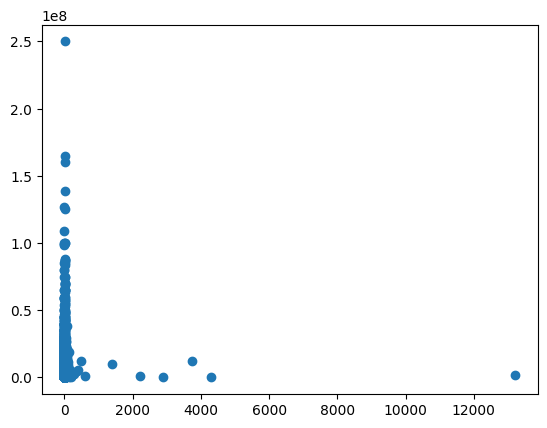

In [ ]:
plt.scatter(data.bedroom_number,data.price)

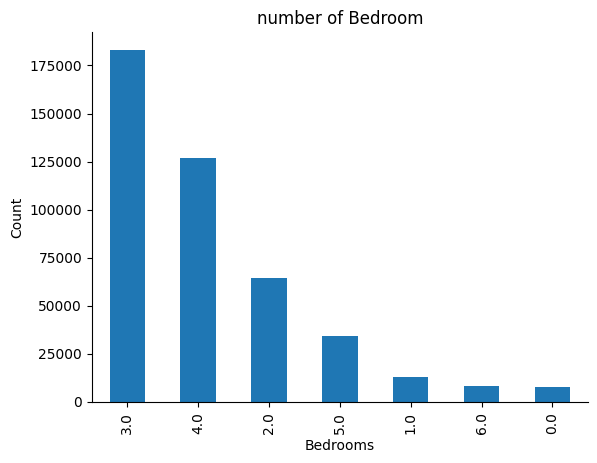

In [ ]:
Q1 = data['bedroom_number'].quantile(0.15)
Q3 = data['bedroom_number'].quantile(0.85)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

filtered_data = data[(data['bedroom_number']>lower_limit) & (data['bedroom_number']<upper_limit)]

filtered_data['bedroom_number'].value_counts().plot(kind='bar')
plt.title('number of Bedroom')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine()

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

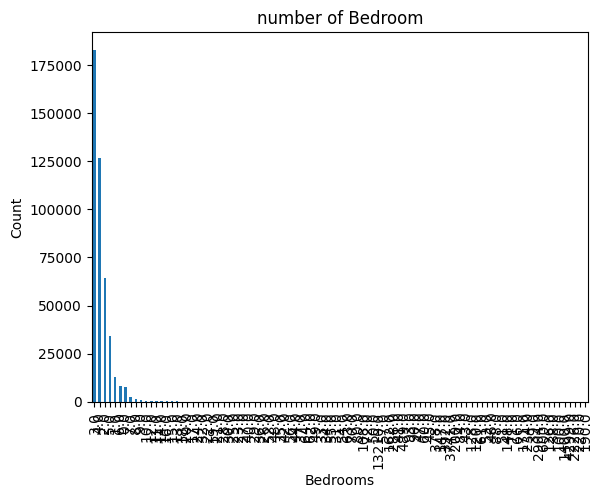

In [ ]:
data['bedroom_number'].value_counts().plot(kind='bar')
plt.title('number of Bedroom')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine

In [ ]:
data.describe()

,property_id,latitude,longitude,price,bedroom_number,bathroom_number,price_per_unit,living_space,land_space,broker_id,year_build,total_num_units,listing_age,agent_name,agent_phone,is_owned_by_zillow
count,6.000000e+05,529122.000000,529122.000000,6.000000e+05,443845.000000,471733.000000,4.353650e+05,4.478470e+05,5.151190e+05,0.0,0.0,0.0,600000.0,0.0,0.0,600000.000000
mean,8.885042e+08,36.282379,-105.813906,6.051870e+05,3.411964,2.471116,4.840448e+02,4.298387e+03,3.099427e+03,NaN,NaN,NaN,-1.0,NaN,NaN,0.000498
std,9.724708e+08,5.673355,13.464633,3.175555e+06,22.491600,5.684972,2.985527e+04,1.780201e+05,5.350082e+03,NaN,NaN,NaN,0.0,NaN,NaN,0.022318
min,2.700000e+01,18.985142,-165.408250,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.306800e+04,NaN,NaN,NaN,-1.0,NaN,NaN,0.000000
25%,5.402143e+07,32.612112,-117.346079,1.700000e+05,3.000000,2.000000,1.550000e+02,1.360000e+03,1.010000e+00,NaN,NaN,NaN,-1.0,NaN,NaN,0.000000
50%,2.066090e+08,35.403568,-101.897378,3.699000e+05,3.000000,2.000000,2.200000e+02,1.863000e+03,6.000000e+01,NaN,NaN,NaN,-1.0,NaN,NaN,0.000000
75%,2.066867e+09,39.661674,-95.354245,6.250000e+05,4.000000,3.000000,3.310000e+02,2.574000e+03,6.534000e+03,NaN,NaN,NaN,-1.0,NaN,NaN,0.000000
max,2.146997e+09,71.299170,-87.525570,2.147484e+09,13210.000000,1892.000000,1.590000e+07,5.991327e+07,1.746756e+06,NaN,NaN,NaN,-1.0,NaN,NaN,1.000000


# Data Cleansing

In [ ]:
cleaned_df = data[['property_id', 'agency_name','bedroom_number', 'bathroom_number', 'living_space', 'property_type', 'property_status', 
                   'city', 'postcode', 'latitude', 'longitude', 'price', 'is_owned_by_zillow', 'listing_age', 'year_build', 'total_num_units']]

In [ ]:
final_df = cleaned_df

In [ ]:
final_df.head()

,property_id,agency_name,bedroom_number,bathroom_number,living_space,property_type,property_status,city,postcode,latitude,longitude,price,is_owned_by_zillow,listing_age,year_build,total_num_units
0,2064212272,Anchor Properties,NaN,NaN,NaN,LOT,FOR_SALE,Wrangell,99929,NaN,NaN,135000.0,0,-1,NaN,NaN
1,249518113,NaN,3.0,3.0,2478.0,SINGLE_FAMILY,FOR_SALE,Wrangell,99929,56.474518,-132.38600,589500.0,0,-1,NaN,NaN
2,2077729913,NaN,NaN,0.0,NaN,LOT,FOR_SALE,Wrangell,99929,56.471638,-132.38686,99999.0,0,-1,NaN,NaN
3,2067488502,"Petersburg Properties, LLC",3.0,1.0,1500.0,SINGLE_FAMILY,FOR_SALE,Wrangell,99929,NaN,NaN,495000.0,0,-1,NaN,NaN
4,249518139,NaN,5.0,3.0,2080.0,SINGLE_FAMILY,FOR_SALE,Wrangell,99929,56.475697,-132.38905,405000.0,0,-1,NaN,NaN


In [ ]:
top_n = 3  # change this to get the top 'n' agencies
top_agencies = final_df['agency_name'].value_counts().head(top_n)
print(top_agencies)

Coldwell Banker Realty    5936
Compass                   4470
eXp Realty                3570
Name: agency_name, dtype: int64


In [ ]:
top_n = 5  # change this to get the top 'n' agencies
top_agencies = final_df['city'].value_counts().head(top_n)
print(top_agencies)

Chicago        14138
Houston        11404
San Antonio     7767
Las Vegas       6303
Los Angeles     4593
Name: city, dtype: int64


In [ ]:
top_n = 100  # change this to get the top 'n' agencies
top_types = final_df['property_type'].value_counts().head(top_n)
print(top_types)

SINGLE_FAMILY    354366
LOT              154662
CONDO             36814
TOWNHOUSE         20108
MANUFACTURED      17220
MULTI_FAMILY      16481
APARTMENT           349
Name: property_type, dtype: int64


# Narrowing the data to single family homes in Chicago

In [ ]:
##create a DF just for chicago. (we need to have all values in numerical format)

chicago_df = final_df[(final_df['city'] == 'Chicago') & (final_df['property_type'] == 'SINGLE_FAMILY')][['property_id', 'bedroom_number', 'bathroom_number','living_space', 'price', 'latitude', 'longitude', 'postcode']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
##One hot encoding to convert strings to numerical values
## create new columns for 'CONDO' , 'SINGLE_FAMILY', 'MULTI-FAMILY', 'TOWNHOUSE', 'MANUFACTURED' with no data in them right away, then fill in, and create new dataframe.
## Drop the 'LOT' type as it will throw off our training data
## 0 for not that type, 1 for that type of property

In [ ]:
for property_type in chicago_df:
    print(chicago_df[property_type].unique())

[   4096493    4096811    4097533 ...  101440827    3846574 2075746714]
[ 3.  4.  2.  5.  6.  7.  8.  9.  1.  0. 12.]
[ 2.  1.  3.  4.  5.  6.  7.  8. nan  9. 11. 10. 13.]
[1417. 1300. 1098. ... 1684. 5457. 7900.]
[1.999000e+05 3.150000e+05 3.099000e+05 3.499000e+05 2.599000e+05
 3.650000e+05 1.399000e+05 5.399000e+05 5.599000e+05 4.299000e+05
 1.250000e+05 2.999000e+05 2.440000e+05 3.990000e+05 4.250000e+05
 7.990000e+05 4.490000e+05 4.990000e+05 3.699000e+05 3.799000e+05
 3.399000e+05 5.250000e+05 4.249000e+05 4.000000e+05 4.599000e+05
 5.999000e+05 5.199990e+05 8.499000e+05 4.199000e+05 3.290000e+05
 5.000000e+05 4.099000e+05 3.349000e+05 3.750000e+05 6.250000e+05
 4.899000e+05 6.499000e+05 3.899000e+05 6.299000e+05 4.475000e+05
 5.949000e+05 5.255550e+05 4.150000e+05 2.250000e+05 3.980000e+05
 4.999990e+05 4.390000e+05 4.499990e+05 4.149000e+05 4.790000e+05
 7.250000e+05 4.800000e+05 8.650000e+05 2.000000e+06 8.500000e+05
 7.799000e+05 6.290000e+05 2.990000e+05 2.649000e+05 2.52000

In [ ]:
#chicago_df.drop(chicago_df[chicago_df['property_type'] == 'LOT'].index, inplace = True)
#chicago_df.drop(chicago_df[chicago_df['property_type'] == 'MANUFACTURED'].index, inplace = True)

In [ ]:
# Get unique values in 'postcode'
unique_postcodes = chicago_df['postcode'].unique()

# Print unique values
for postcode in unique_postcodes:
    print(postcode)

60655
60803
60656
60660
60652
60643
60647
60609
60616
60608
60653
60632
60636
60612
60644
60607
60628
60637
60640
60639
60618
60641
60634
60654
60620
60629
60645
60638
60624
60621
60630
60646
60625
60617
60613
60614
60659
60622
60603
60651
60610
60642
60615
60605
60626
60601
60619
60657
60631
60623
60649
60633
60411
60302
60426
60611


# Condensing the postcode 

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Fit the encoder and transform the 'postcode' column
chicago_df['post_code'] = le.fit_transform(chicago_df['postcode'])

# Drop the original 'postcode' column
chicago_df = chicago_df.drop('postcode', axis=1)

In [ ]:
##find if we have nan or null data

check_nan = chicago_df['price'].isnull().values.any()
 
# printing the result
print(check_nan)

False


In [ ]:
chicago_df.head()

,property_id,bedroom_number,bathroom_number,living_space,price,latitude,longitude,post_code
572679,4096493,3.0,2.0,1417.0,199900.0,41.690260,-87.707740,50
572683,4096811,3.0,2.0,1300.0,315000.0,41.686848,-87.710045,50
572688,4097533,4.0,2.0,1300.0,309900.0,41.682007,-87.711320,50
572701,4098042,3.0,2.0,1098.0,349900.0,41.682095,-87.705696,50
572722,113956069,3.0,2.0,1710.0,259900.0,41.671726,-87.711460,55


In [ ]:
# Create new columns for each property type
#chicago_df['IS_CONDO'] = (chicago_df['property_type'] == 'CONDO').astype(int)
#chicago_df['IS_SINGLE_FAMILY'] = (chicago_df['property_type'] == 'SINGLE_FAMILY').astype(int)
#chicago_df['IS_MULTI_FAMILY'] = (chicago_df['property_type'] == 'MULTI_FAMILY').astype(int)
#chicago_df['IS_TOWNHOUSE'] = (chicago_df['property_type'] == 'TOWNHOUSE').astype(int)

# Drop the original 'property_type' column
#chicago_df.drop('property_type', axis=1, inplace=True)

In [ ]:
## drop the old index (random number assigned to properties), and set property_id (assigned by zillow) as the index as it is a unique identifier.

# reset the old index and drop it
chicago_df.reset_index(drop=True, inplace=True)

# set 'property_id' as the new index
chicago_df.set_index('property_id', inplace=True)

In [ ]:
chicago_df.head(50)

,bedroom_number,bathroom_number,living_space,price,latitude,longitude,post_code
property_id,,,,,,,
4096493,3.0,2.0,1417.0,199900.0,41.690260,-87.707740,50
4096811,3.0,2.0,1300.0,315000.0,41.686848,-87.710045,50
4097533,4.0,2.0,1300.0,309900.0,41.682007,-87.711320,50
4098042,3.0,2.0,1098.0,349900.0,41.682095,-87.705696,50
113956069,3.0,2.0,1710.0,259900.0,41.671726,-87.711460,55
4096187,4.0,2.0,1522.0,365000.0,41.685120,-87.713660,50
4082885,2.0,1.0,4961.0,139900.0,41.692240,-87.720030,50
4097056,5.0,3.0,2742.0,539900.0,41.685005,-87.708750,50
4096618,4.0,4.0,2500.0,559900.0,41.690860,-87.704810,50


# Data Visualization after clean up 

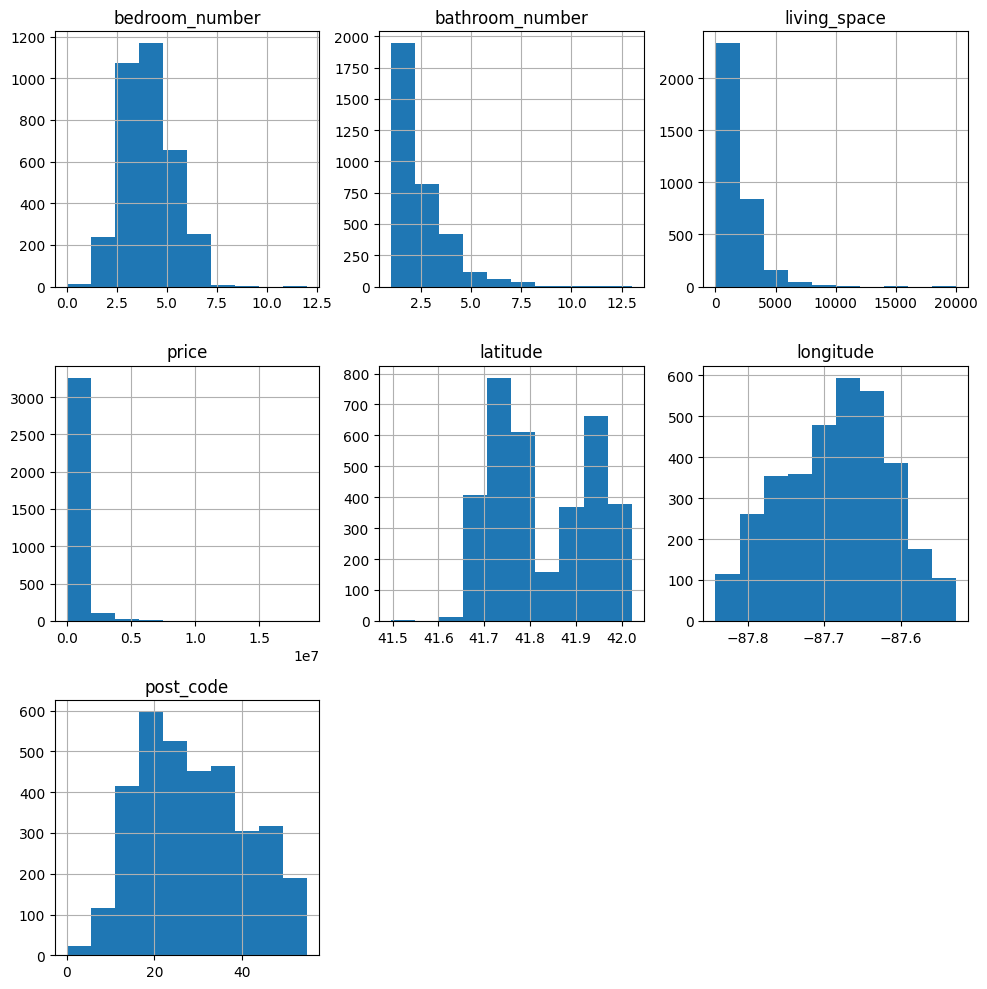

In [ ]:
chicago_df.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

In [ ]:
min_price = chicago_df['price'].min()
max_price = chicago_df['price'].max()
mean_price = chicago_df['price'].mean()
median_price = chicago_df['price'].median()

print(f"Minimum Price: {min_price}")
print(f"Maximum Price: {max_price}")
print(f"Mean Price: {mean_price}")
print(f"Median Price: {median_price}")

Minimum Price: 0.0
Maximum Price: 18750000.0
Mean Price: 530849.8387191539
Median Price: 299900.0


In [ ]:
zero_price_count = (chicago_df['price'] == 0).sum()

print(f"Number of times price equals 0: {zero_price_count}")

Number of times price equals 0: 8


# Removing Outliers

In [ ]:
chicago_df = chicago_df[(chicago_df['price'] >= 200000) & (chicago_df['price'] <= 2000000) & (chicago_df['living_space'] > 600)]

In [ ]:
min_price = chicago_df['price'].min()
max_price = chicago_df['price'].max()
mean_price = chicago_df['price'].mean()
median_price = chicago_df['price'].median()

print(f"Minimum Price: {min_price}")
print(f"Maximum Price: {max_price}")
print(f"Mean Price: {mean_price}")
print(f"Median Price: {median_price}")

Minimum Price: 200000.0
Maximum Price: 2000000.0
Mean Price: 484185.9812030075
Median Price: 349900.0


# Model Training

In [ ]:
import pandas as pd
import boto3
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


chicago_df = chicago_df.dropna()


# Feature Engineering and Outlier Handling
chicago_df['bath_bed_ratio'] = chicago_df['bathroom_number'] / chicago_df['bedroom_number']
Q1 = chicago_df.quantile(0.25)
Q3 = chicago_df.quantile(0.75)
IQR = Q3 - Q1
chicago_df = chicago_df[~((chicago_df < (Q1 - 1.5 * IQR)) |(chicago_df > (Q3 + 1.5 * IQR))).any(axis=1)]

chicago_df = chicago_df.dropna()


# Split data
X = chicago_df.drop('price', axis=1) 
y = chicago_df['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Normalization
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns = X_valid.columns)

# Reset indices
y_train = y_train.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

# Save the train and validation data to CSV files
pd.concat([y_train, X_train], axis=1).to_csv("train.csv", index=False, header=False)
pd.concat([y_valid, X_valid], axis=1).to_csv("validation.csv", index=False, header=False)

# Upload the train and validation data to S3
s3 = boto3.resource('s3')
s3.meta.client.upload_file('train.csv', '<Put your bucket name>', 'train/train.csv')
s3.meta.client.upload_file('validation.csv', '<Put your bucket name>', 'validation/validation.csv')

# Create a SageMaker Estimator for the XGBoost algorithm

container = get_image_uri(boto3.Session().region_name, 'xgboost', '1.7-1')
xgb = sagemaker.estimator.Estimator(container, role, train_instance_count=1, train_instance_type='ml.m4.xlarge', output_path='s3://<Put your bucket name>/output', sagemaker_session=sagemaker.Session())

# Define the hyperparameter ranges
hyperparameter_ranges = {
    'max_depth': IntegerParameter(1,30),
    'eta': ContinuousParameter(0.01, 0.5),
    'min_child_weight': IntegerParameter(1, 20),
    'subsample': ContinuousParameter(0.1, 0.9),
    'gamma': ContinuousParameter(0, 20),
    'colsample_bytree': ContinuousParameter(0.1, 1),
    'colsample_bylevel': ContinuousParameter(0.1, 1),
    'lambda': ContinuousParameter(0, 5),
    'alpha': ContinuousParameter(0, 5),
    'num_round': IntegerParameter(10, 500)
}

# Set the hyperparameters for the XGBoost algorithm
xgb.set_hyperparameters(objective='reg:squarederror', early_stopping_rounds=30, num_round=300, verbosity=1)

# Define the objective metric
objective_metric_name = 'validation:rmse'
objective_type = 'Minimize'

# Create the hyperparameter tuner
tuner = HyperparameterTuner(xgb, objective_metric_name, hyperparameter_ranges, max_jobs=9, max_parallel_jobs=3, objective_type=objective_type)

# Prepare the input channels
s3_input_train = TrainingInput(s3_data='s3://<Put your bucket name>/train/', content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://<Put your bucket name>/validation/', content_type='csv')

# Start the hyperparameter tuning job
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

# Get the information about the best training job
best_training_job_info = tuner.describe()
best_training_job_name = best_training_job_info['BestTrainingJob']['TrainingJobName']

# Get the information about the best training job using the SageMaker client
sagemaker_session = sagemaker.Session()
best_training_job_info = sagemaker_session.describe_training_job(best_training_job_name)

# Extract the chosen hyperparameters
best_hyperparameters = best_training_job_info['HyperParameters']

# Display the best hyperparameters
print("Best hyperparameters:")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")

# Fetch the RMSE data for the best training job
metric_name = 'validation:rmse'
metrics_dataframe = TrainingJobAnalytics(training_job_name=best_training_job_name, metric_names=[metric_name]).dataframe()


# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the validation data
y_pred_rf = rf.predict(X_valid)

# Calculate the RMSE of the Random Forest Regressor
rmse_rf = np.sqrt(mean_squared_error(y_valid, y_pred_rf))

# Compare the RMSE of the XGBoost and Random Forest models
rmse_xgb = np.sqrt(metrics_dataframe['value'].min())
print("\nRMSE of XGBoost:", rmse_xgb)
print("RMSE of Random Forest:", rmse_rf)

# Choose the model with the lower RMSE
if rmse_rf < rmse_xgb:
    print("\nThe Random Forest model has a lower RMSE.")
    best_model = rf
    best_rmse = rmse_rf
else:
    print("\nThe XGBoost model has a lower RMSE.")
    best_model = xgb
    best_rmse = rmse_xgb

print("Best model:", best_model)
print("Best RMSE:", best_rmse)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................!
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Best hyperparameters:
_tuning_objective_metric: validation:rmse
alpha: 5.0
colsample_bylevel: 0.9287948794171368
colsample_bytree: 0.6827796368136152
early_stopping_rounds: 30
eta: 0.1224058576480435
gamma: 8.775878897977877
lambda: 3.4335079321447233
max_depth: 8
min_child_weight: 20
num_round: 409
objective: reg:squarederror
subsample: 0.792745184493833
verbosity: 1
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]


RMSE of XGBoost: 281.5219518616621
RMSE of Random Forest: 83179.02330289513

The XGBoost model has a lower RMSE.
Best model: <sagemaker.estimator.Estimator object at 0x7f384c33a8f0>
Best RMSE: 281.5219518616621


# Viewing the data

In [ ]:
chicago_df.head(5)

,bedroom_number,bathroom_number,living_space,price,latitude,longitude,post_code,bath_bed_ratio
property_id,,,,,,,,
4096811,3.0,2.0,1300.0,315000.0,41.686848,-87.710045,50,0.666667
4097533,4.0,2.0,1300.0,309900.0,41.682007,-87.711320,50,0.500000
4098042,3.0,2.0,1098.0,349900.0,41.682095,-87.705696,50,0.666667
113956069,3.0,2.0,1710.0,259900.0,41.671726,-87.711460,55,0.666667
4096187,4.0,2.0,1522.0,365000.0,41.685120,-87.713660,50,0.500000


# Correlation between various attributes 

In [ ]:
correlation_matrix = chicago_df.corr()
print(correlation_matrix)

                 bedroom_number  bathroom_number  ...  post_code  bath_bed_ratio
bedroom_number         1.000000         0.459051  ...  -0.055958       -0.333958
bathroom_number        0.459051         1.000000  ...  -0.034663        0.651136
living_space           0.419406         0.585201  ...  -0.018141        0.230116
price                  0.191676         0.535300  ...   0.070991        0.357507
latitude              -0.062928         0.090711  ...   0.162992        0.142341
longitude              0.127790         0.092201  ...  -0.387017       -0.011695
post_code             -0.055958        -0.034663  ...   1.000000        0.005113
bath_bed_ratio        -0.333958         0.651136  ...   0.005113        1.000000

[8 rows x 8 columns]


# Setting up endpoints for inferencing

In [ ]:
from sagemaker import estimator
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# Fetch the information about the best training job
best_training_job_info = tuner.best_training_job()
best_model = estimator.Estimator.attach(best_training_job_info)

# Deploy the best model
## This is going to deploy a SageMaker endpoint instance with what we specify here (type, count, model to deploy)
predictor = best_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# Specify the serializer and deserializer
predictor.serializer = CSVSerializer()
predictor.deserializer = CSVDeserializer()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml

2023-11-09 22:15:32 Starting - Found matching resource for reuse
2023-11-09 22:15:32 Downloading - Downloading input data
2023-11-09 22:15:32 Training - Training image download completed. Training in progress.
2023-11-09 22:15:32 Uploading - Uploading generated training model
2023-11-09 22:15:32 Completed - Resource reused by training job: sagemaker-xgboost-231109-2210-008-7026d167
------!

# Running the inferences and printing predicted values

In [ ]:
import pandas as pd
from sagemaker.serializers import CSVSerializer

# Create a DataFrame from your data
# This data is randomly picked from the validation set (not trained data) so as not to introduce bias. 
valdata = [
    [239500.0, 1.058773594059130, -0.5476783157318450, -0.7791248933295790, -0.8571485224099410, 2.0614927046585300, -1.3169590357952400, -1.1994104934014300],
    [799000.0, 0.07967139607036990, 1.9854403638739200, 1.6238737384246800, 1.1967044241520300, -0.14807632643541900, -0.613129362862038, 1.8274192687972600],
    [355000.0, -0.8994308019183920, -0.5476783157318450, -1.0087537676399900, 1.4761783480840400, -1.456616669723130, -0.17323581727878500, 0.1458471786868720],
    [304995.0, 1.058773594059130, 0.7188810240710390, 2.374895233228150, -1.3057699752189500, 2.3748879071066400, -1.3169590357952400, -0.19046723933520400],
    [225000.0, 0.07967139607036990, 0.7188810240710390, 0.2717648961616050, 0.45600790759565500, -0.9198871797651460, 0.8825086921210230, 0.5662402012144680],
    [405000.0, 0.07967139607036990, -0.5476783157318450, -0.7115869891206340, 1.2227986519323200, -0.6646120336032080, -0.26121452639543500, -0.694938866368319],
    [224900.0, 3.016977990036660, -0.5476783157318450, -0.19829891713265200, -1.795658263161210, 2.2328042276388400, 0.0027216009545164600, -1.775949495724990],
    [264000.0, -1.878532999907150, -1.814237655534730, -0.3495838225606890, 0.9381153712542950, -1.0037948644902400, 0.09070031007116710, -0.694938866368319]
]
fake_data_df = pd.DataFrame(valdata)
actuals = fake_data_df[0].tolist()
# Remove the first column (price)
fake_data_df = fake_data_df.iloc[:, 1:]

# Convert the DataFrame to CSV format
fake_data_csv = fake_data_df.to_csv(sep=',', header=False, index=False)

# Make a prediction
prediction = predictor.predict(fake_data_csv)

# Print the prediction
print(prediction)

[['251705.765625'], ['768936.5'], ['411884.875'], ['294603.875'], ['322291.15625'], ['410650.125'], ['231185.5625'], ['329626.75']]


# Comparing predicted values to actual values

In [ ]:
# Convert the predictions to a list of floats
predictions = [float(pred[0]) for pred in prediction]

# Calculate the absolute percentage error for each prediction
errors = [abs((pred - actual) / actual * 100) for pred, actual in zip(predictions, actuals)]

# Print the errors
for i, error in enumerate(errors):
    print(f"Prediction: {predictions[i]}, Actual: {actuals[i]}, Error: {error}%")

Prediction: 251705.765625, Actual: 239500.0, Error: 5.096353079331942%
Prediction: 768936.5, Actual: 799000.0, Error: 3.7626408010012518%
Prediction: 411884.875, Actual: 355000.0, Error: 16.023908450704223%
Prediction: 294603.875, Actual: 304995.0, Error: 3.40698208167347%
Prediction: 322291.15625, Actual: 225000.0, Error: 43.240513888888884%
Prediction: 410650.125, Actual: 405000.0, Error: 1.3950925925925926%
Prediction: 231185.5625, Actual: 224900.0, Error: 2.794825477990218%
Prediction: 329626.75, Actual: 264000.0, Error: 24.858617424242425%
